In [12]:
import pandas as pd

# data
from mlforecast.utils import generate_daily_series, generate_prices_for_series, generate_series
# forecast and feature engine
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from utilsforecast.plotting import plot_series

# model
import lightgbm as lgb

# data

## series

In [8]:
series = generate_daily_series(
    n_series=100,
    # max_length=300,
    equal_ends=True,
    n_static_features=2,
    static_as_categorical=False,
    with_trend = True,
).rename(columns = {"static_1": "product_id"})

print(series.head())
print()
print(series.tail())
print()
print(series.shape)
print()
print(series["unique_id"].value_counts())

  unique_id         ds           y  static_0  product_id
0     id_00 2000-10-05   39.811983        79          45
1     id_00 2000-10-06  103.757103        79          45
2     id_00 2000-10-07  177.540923        79          45
3     id_00 2000-10-08  260.437170        79          45
4     id_00 2000-10-09  346.872764        79          45

      unique_id         ds           y  static_0  product_id
26998     id_99 2001-05-10  495.480733        69          35
26999     id_99 2001-05-11   72.548795        69          35
27000     id_99 2001-05-12  143.872122        69          35
27001     id_99 2001-05-13  188.521837        69          35
27002     id_99 2001-05-14  271.200164        69          35

(27003, 5)

unique_id
id_46    499
id_35    498
id_72    492
id_34    481
id_83    480
        ... 
id_51     81
id_73     81
id_58     78
id_25     75
id_08     59
Name: count, Length: 100, dtype: int64


## price

In [15]:
prices_catalog = generate_prices_for_series(series)
print(prices_catalog.head())
print()
print(prices_catalog.tail())
print()
print(prices_catalog.shape)
print()
print(prices_catalog["unique_id"].value_counts())
print()
print(series.loc[series["unique_id"] == "id_08"])
print()
print(prices_catalog.loc[prices_catalog["unique_id"] == "id_08"])

          ds unique_id     price
0 2000-10-05     id_00  0.548814
1 2000-10-06     id_00  0.715189
2 2000-10-07     id_00  0.602763
3 2000-10-08     id_00  0.544883
4 2000-10-09     id_00  0.423655

              ds unique_id     price
27698 2001-05-17     id_99  0.682296
27699 2001-05-18     id_99  0.123657
27700 2001-05-19     id_99  0.068762
27701 2001-05-20     id_99  0.324157
27702 2001-05-21     id_99  0.605791

(27703, 3)

unique_id
id_46    506
id_35    505
id_72    499
id_34    488
id_83    487
        ... 
id_51     88
id_73     88
id_58     85
id_25     82
id_08     66
Name: count, Length: 100, dtype: int64

     unique_id         ds           y  static_0  product_id
2056     id_08 2001-03-17  331.026336        62          73
2057     id_08 2001-03-18  395.310527        62          73
2058     id_08 2001-03-19   22.332969        62          73
2059     id_08 2001-03-20   74.562499        62          73
2060     id_08 2001-03-21  136.784995        62          73
2061     id_0

## series with price

In [9]:
series_with_prices = series.merge(prices_catalog, how = "left")
print(series_with_prices.head())
print()
print(series_with_prices.tail())
print()
print(series_with_prices.shape)
print()
print(series_with_prices["unique_id"].value_counts())

  unique_id         ds           y  static_0  product_id     price
0     id_00 2000-10-05   39.811983        79          45  0.548814
1     id_00 2000-10-06  103.757103        79          45  0.715189
2     id_00 2000-10-07  177.540923        79          45  0.602763
3     id_00 2000-10-08  260.437170        79          45  0.544883
4     id_00 2000-10-09  346.872764        79          45  0.423655

      unique_id         ds           y  static_0  product_id     price
26998     id_99 2001-05-10  495.480733        69          35  0.112841
26999     id_99 2001-05-11   72.548795        69          35  0.883449
27000     id_99 2001-05-12  143.872122        69          35  0.762250
27001     id_99 2001-05-13  188.521837        69          35  0.025932
27002     id_99 2001-05-14  271.200164        69          35  0.651356

(27003, 6)

unique_id
id_46    499
id_35    498
id_72    492
id_34    481
id_83    480
        ... 
id_51     81
id_73     81
id_58     78
id_25     75
id_08     59
Name:

## sereis plot

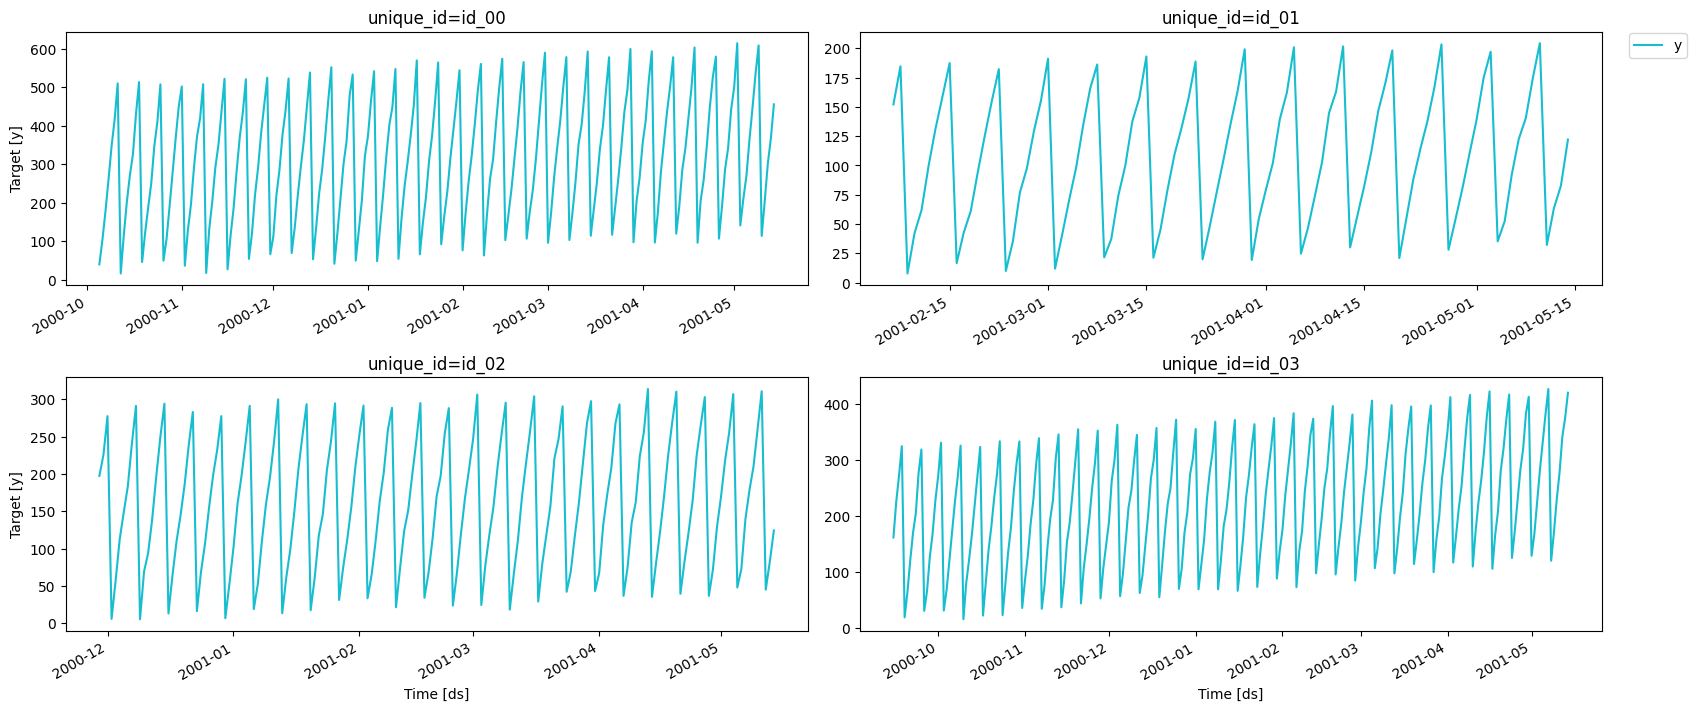

In [11]:
fig = plot_series(series_with_prices, max_ids = 4, plot_random = False)
fig

# model training

## model

In [ ]:
fcst = MLForecast(
    models = lgb.LGBMRegressor(n_jobs = 1, random_state = 0, verbosity = -1),
    freq = "D",
    lags = [7],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=14)],
    },
    date_features=["dayofweek", "month"],
    num_threads = 2,
)

## training

In [13]:
fcst.fit(series_with_prices, static_features=["static_0", "product_id"])

MLForecast(models=[LGBMRegressor], freq=D, lag_features=['lag7', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size14'], date_features=['dayofweek', 'month'], num_threads=2)

## features

In [14]:
fcst.ts.features_order_

['static_0',
 'product_id',
 'price',
 'lag7',
 'expanding_mean_lag1',
 'rolling_mean_lag7_window_size14',
 'dayofweek',
 'month']

# model predicting

In [16]:
preds = fcst.predict(h = 7, X_df = prices_catalog)
print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id         ds  LGBMRegressor
0     id_00 2001-05-15     535.397707
1     id_00 2001-05-16     611.116803
2     id_00 2001-05-17     121.252977
3     id_00 2001-05-18     204.960144
4     id_00 2001-05-19     304.515885

(700, 3)

unique_id
id_00    7
id_63    7
id_73    7
id_72    7
id_71    7
        ..
id_30    7
id_29    7
id_28    7
id_27    7
id_99    7
Name: count, Length: 100, dtype: int64


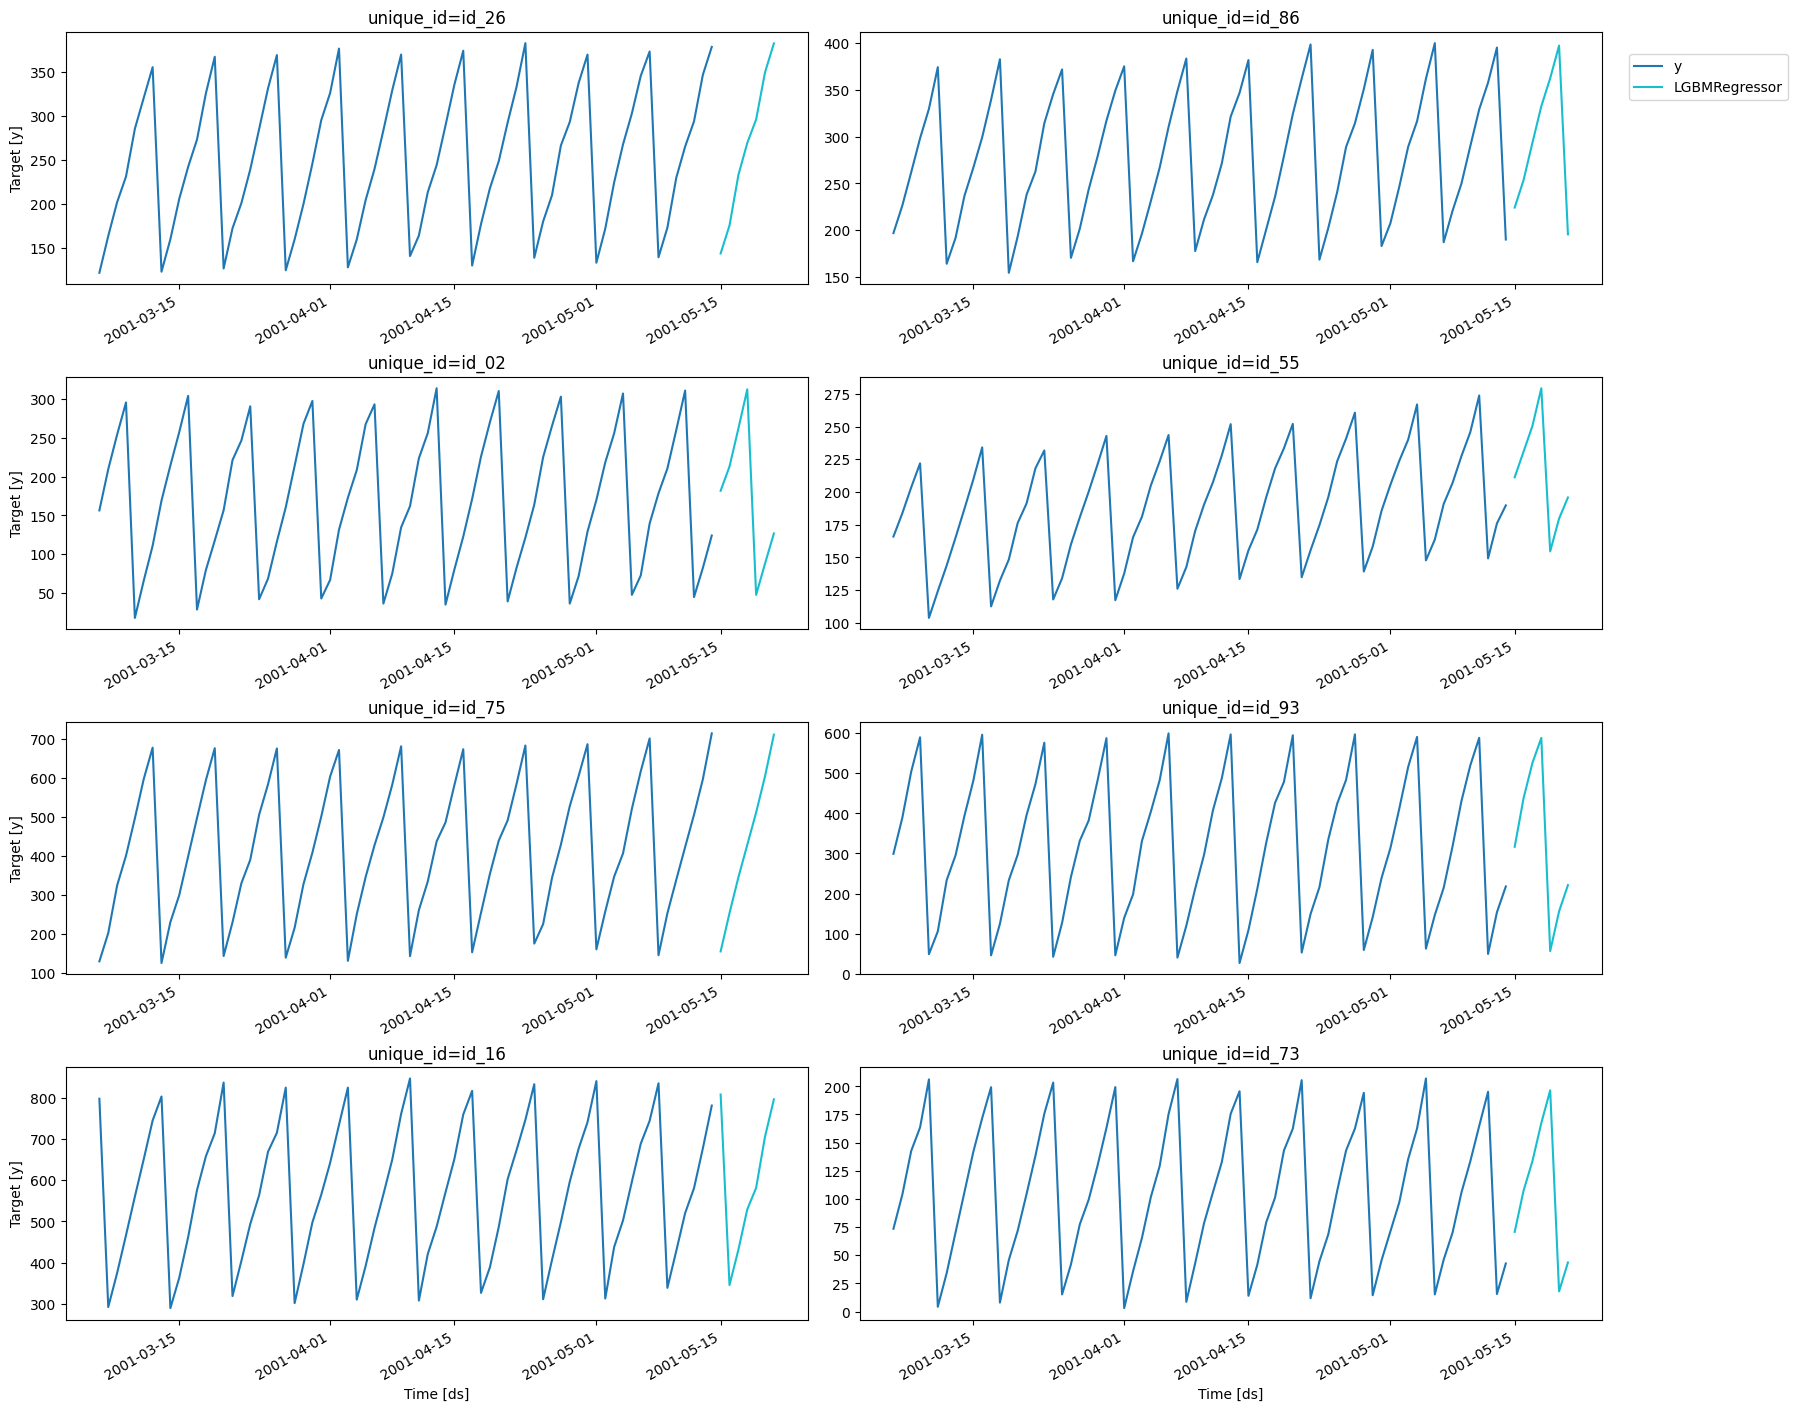

In [21]:
fig = plot_series(series_with_prices, preds, max_insample_length = 10*7)
fig